## Simple Measurement System

In [1]:
import threading
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import datetime
from model import signalprocessing as sp
from model.measurement import MeasBNO055
from model.tools import wait_process

In [3]:
class measurement_control:
    def __init__(self, BNO_UPDATE_FREQUENCY_HZ = 10, Isautosave = True):
        self.ctrlbutton_state = 'stop'# stop/start
        self.ctrl_button = widgets.Button(description="▶",layout=lay(120,50)) 
        self.save_button = widgets.Button(description="Save",layout=lay(120,50))
        self.calib_button = widgets.Button(description="Calib",layout=lay(120,50))
        
        self.output = widgets.Output(layour={'border': '1px solid black'})       
        self.measurement = MeasBNO055(BNO_UPDATE_FREQUENCY_HZ=BNO_UPDATE_FREQUENCY_HZ)
        self.Isstart = False
        self.start_thread = None
        self.stop_thread = None
        self.save_thread = None
        self.calib_thread = None
        self.buttonState = "stop"
        self.elapsed_time = 0
        self.itr_end_time = 0
        self.logic_end_time = 0
        self.logic_start_time = 0
        self.itr_start_time = 0
        self.Isautosave = Isautosave
        
    def start(self):
        
        self.Isstart = True
        self.stop_thread = None
        #print('Measurement Start')
        self.ctrl_button.description = '■'
        self.ctrl_button.button_style = 'success'
        
        
        #Measurement main logic
        try:
            self.logic_start_time = time.time()#Logic start time
            counter = 0# Clock

            
            while self.Isstart:
                self.itr_start_time = time.time()# Start time of iteration loop
                Time = counter / self.measurement.BNO_UPDATE_FREQUENCY_HZ# Current time
                
                #Time, euler_x, euler_y, euler_z, gyro_x, gyro_y, gyro_z, gravity_x, gravity_y, gravity_z,\
                #linear_accel_x, linear_accel_y, linear_accel_z, accel_x, accel_y, accel_z,\
                #quaternion_1, quaternion_2, quaternion_3, quaternion_4,\
                #calibstat_sys, calibstat_gyro, calibstat_accel, calibstat_mag]
                                 
                data = np.array([Time] + list(self.measurement.get_data(self.measurement.bno))).reshape(-1, len(self.measurement.COLUMNS))# Get data from sensor and merge time
                
                            
                if counter == 0:
                    
                    self.measurement.assy_data = data.copy()

                else: 
                    self.measurement.assy_data = np.concatenate((self.measurement.assy_data, data), axis = 0)# Concatenate data
        
                self.itr_end_time = time.time()# End time of iteration loop
   
                wait_process((1.0 / self.measurement.BNO_UPDATE_FREQUENCY_HZ) - (self.itr_end_time - self.itr_start_time))# For keeping sampling frequency
                counter += 1

            self.logic_end_time = time.time()
            # Elapsed time
            self.elapsed_time = self.logic_end_time - self.logic_start_time         
            
                            
        except Exception as e:
            self.logic_end_time = time.time()
            #Elapsed time
            elapsed_time = self.logic_end_time - self.logic_start_time
            print('Error! Save data')
            self.save()
            return

        
    def stop(self):
        self.Isstart = False
        self.start_thread = None
        try:
            if meas_ctrl.Isautosave:
                self.save()
            self.ctrl_button.description = '▶'
            self.ctrl_button.button_style = ''
        except Exception as e:
            print('Error!')
        
        return

    def save(self):
        try:
            self.save_button.description = 'Saving...'
            self.save_button.button_style = 'success'
            self.measurement.assy_data = pd.DataFrame(self.measurement.assy_data, columns=list(self.measurement.COLUMNS))
            self.measurement.assy_data_offset = self.measurement.assy_data.copy()
            
            
            
            t_delta = datetime.timedelta(hours=9)
            JST = datetime.timezone(t_delta, 'JST')# You have to set your timezone
            now = datetime.datetime.now(JST)
            timestamp = now.strftime('%Y%m%d%H%M%S')
            self.measurement.assy_data.to_csv(self.measurement.datapath + '/'+ timestamp +'_data.csv')
            
            self.offset(offset_len=10, offset_mode='median')
            self.measurement.assy_data_offset.to_csv(self.measurement.datapath + '/'+ timestamp +'_offsetdata.csv')
            
            
            self.measurement.assy_data_filter = self.measurement.assy_data_offset.copy()
            labellist = self.measurement.assy_data_filter.columns
            labellist = labellist.drop(['Time', 'calibstat_sys', 'calibstat_gyro', 'calibstat_accel','calibstat_mag'])
            labellist = list(labellist)
            self.measurement.assy_data_filter = self.filtering(self.measurement.assy_data_filter, samplerate=1/self.measurement.BNO_UPDATE_FREQUENCY_HZ, labellist=labellist, fpass=2, fstop=5, gpass=1, gstop=2)
            self.measurement.assy_data_offset.to_csv(self.measurement.datapath + '/'+ timestamp +'_filterdata.csv')
            
            wait_process(0.5)# For user friendly
            
            self.save_button.description = 'Save'
            self.save_button.button_style = ''
            self.save_thread = None
        except Exception:
            pass

    def get_calib_stat(self):
        calibstat_sys, calibstat_gyro, calibstat_accel, calibstat_mag = [val for val in self.measurement.bno.calibration_status]
        print("sys, gyro, accel, mag: {0}, {1}, {2}, {3}".format(calibstat_sys, calibstat_gyro, calibstat_accel, calibstat_mag))

        
    def offset(self, offset_len=10, offset_mode='median'):
        

        offset = self.measurement.assy_data_offset.iloc[:offset_len,:]  
        if offset_mode == 'median':
            offset_val = offset.median(axis=0)        
        elif offset_mode == 'mean':
            offset_val = offset.mean(axis=0)
        else:
            print('Error')
            exit
        offset_val['Time'], offset_val['calibstat_sys'],offset_val['calibstat_gyro'], offset_val['calibstat_accel'], offset_val['calibstat_mag'] = 0,0,0,0,0
        self.measurement.assy_data_offset = self.measurement.assy_data_offset - offset_val

    def filtering(self, df, samplerate, labellist, fpass=8, fstop=10, gpass=3, gstop=10):
        filtered_df = df.copy()
        for idx, labelname in enumerate(labellist):
            filtered_df[labelname] = sp.butterlowpass(x=df[labelname], 
                                                        fpass=fpass,
                                                        fstop=fstop,
                                                        gpass=gpass,
                                                        gstop=gstop,
                                                        fs=1 / samplerate,
                                                        dt=samplerate,
                                                        checkflag=False,
                                                        labelname=labelname)
        return filtered_df
        

    def Run(self):
        #@self.output.capture()
        def on_click_ctrlbutton_callback(clicked_button: widgets.Button) -> None:
            if self.ctrlbutton_state == 'stop':
                if self.start_thread == None :
                    self.ctrlbutton_state = 'start'
                    self.start_thread = threading.Thread(target=self.start)
                    self.start_thread.start()
                
            elif self.ctrlbutton_state == 'start':
                if self.stop_thread == None :
                    self.ctrlbutton_state = 'stop'
                    self.stop_thread = threading.Thread(target=self.stop)
                    self.stop_thread.start()
                    
        def on_click_savebutton_callback(clicked_button: widgets.Button) -> None:
            if self.ctrlbutton_state == 'stop' and self.Isstart == False:
                self.save_thread = threading.Thread(target=self.save)
                self.save_thread.start()
        
        @self.output.capture()
        def on_click_calibbutton_callback(clicked_button: widgets.Button) -> None:
            if self.ctrlbutton_state == 'stop' and self.Isstart == False:
                self.get_calib_stat()
        
            

        self.calib_button.on_click(on_click_calibbutton_callback)
        self.ctrl_button.on_click(on_click_ctrlbutton_callback)
        self.save_button.on_click(on_click_savebutton_callback)

        
def lay(width,height):
    return widgets.Layout(width=str(width)+"px",height=str(height)+"px")
def init_meas_system():
    meas_ctrl = measurement_control(BNO_UPDATE_FREQUENCY_HZ=50, Isautosave=False)
    display(widgets.VBox([
            widgets.HBox([meas_ctrl.ctrl_button, meas_ctrl.save_button, meas_ctrl.calib_button]), 
            meas_ctrl.output]))


    return meas_ctrl
def main_loop():
    meas_ctrl = init_meas_system()
    meas_ctrl.Run()
    return meas_ctrl


In [4]:
meas_ctrl = main_loop()

Established connection with BNO055


In [5]:
#meas_ctrl.elapsed_time
meas_ctrl.logic_end_time - meas_ctrl.logic_start_time - (1.0 / meas_ctrl.measurement.BNO_UPDATE_FREQUENCY_HZ)

11.666169862747193

Text(0,0.5,'Yaw Angle[deg]')

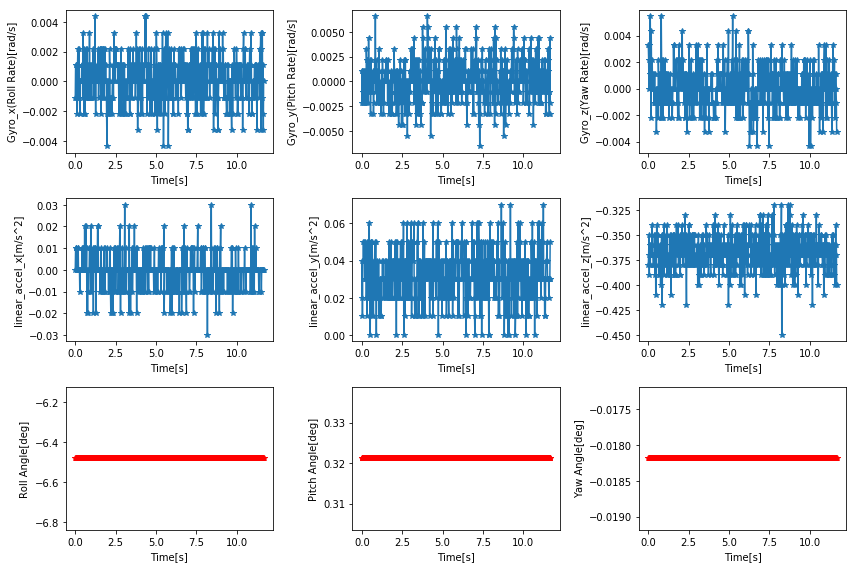

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(12,8), tight_layout=True)
ax[0,0].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['gyro_x'], marker='*')
ax[0,0].set_xlabel('Time[s]')
ax[0,0].set_ylabel('Gyro_x(Roll Rate)[rad/s]')
ax[0,1].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['gyro_y'], marker='*')
ax[0,1].set_xlabel('Time[s]')
ax[0,1].set_ylabel('Gyro_y(Pitch Rate)[rad/s]')
ax[0,2].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['gyro_z'], marker='*')
ax[0,2].set_xlabel('Time[s]')
ax[0,2].set_ylabel('Gyro_z(Yaw Rate)[rad/s]')
ax[1,0].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['linear_accel_x'], marker='*')
ax[1,0].set_xlabel('Time[s]')
ax[1,0].set_ylabel('linear_accel_x[m/s^2]')
ax[1,1].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['linear_accel_y'], marker='*')
ax[1,1].set_xlabel('Time[s]')
ax[1,1].set_ylabel('linear_accel_y[m/s^2]')
ax[1,2].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['linear_accel_z'], marker='*')
ax[1,2].set_xlabel('Time[s]')
ax[1,2].set_ylabel('linear_accel_z[m/s^2]')


ax[2,0].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['Roll'], marker='*', color='r')
ax[2,0].set_xlabel('Time[s]')
ax[2,0].set_ylabel('Roll Angle[deg]')

ax[2,1].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['Pitch'], marker='*',color='r')
ax[2,1].set_xlabel('Time[s]')
ax[2,1].set_ylabel('Pitch Angle[deg]')

ax[2,2].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['Yaw'], marker='*', color='r')
ax[2,2].set_xlabel('Time[s]')
ax[2,2].set_ylabel('Yaw Angle[deg]')


Text(0,0.5,'Yaw Angle[deg]')

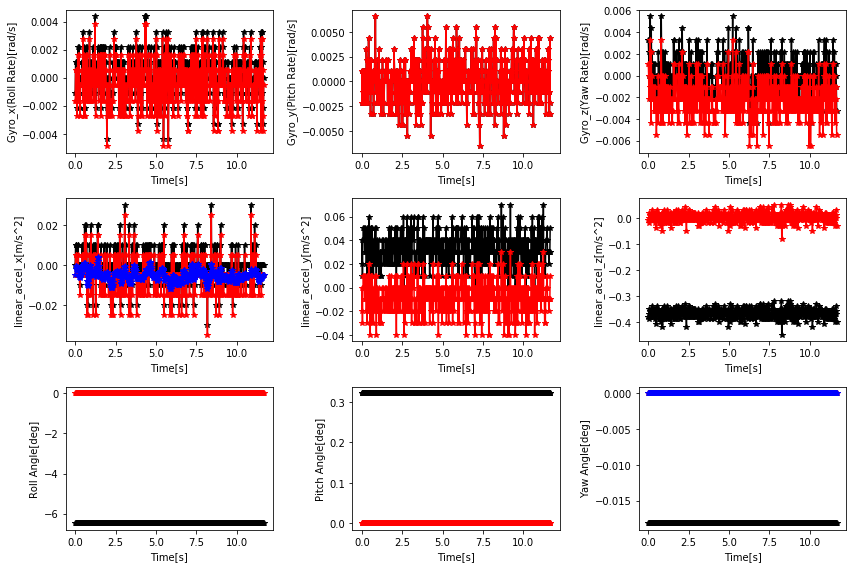

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(12,8), tight_layout=True)
ax[0,0].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['gyro_x'], marker='*',color='k')
ax[0,0].plot(meas_ctrl.measurement.assy_data_offset['Time'], meas_ctrl.measurement.assy_data_offset['gyro_x'], marker='*',color='r')
ax[0,0].set_xlabel('Time[s]')
ax[0,0].set_ylabel('Gyro_x(Roll Rate)[rad/s]')
ax[0,1].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['gyro_y'], marker='*', color='k')
ax[0,1].plot(meas_ctrl.measurement.assy_data_offset['Time'], meas_ctrl.measurement.assy_data_offset['gyro_y'], marker='*',color='r')
ax[0,1].set_xlabel('Time[s]')
ax[0,1].set_ylabel('Gyro_y(Pitch Rate)[rad/s]')
ax[0,2].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['gyro_z'], marker='*',color='k')
ax[0,2].plot(meas_ctrl.measurement.assy_data_offset['Time'], meas_ctrl.measurement.assy_data_offset['gyro_z'], marker='*',color='r')
ax[0,2].set_xlabel('Time[s]')
ax[0,2].set_ylabel('Gyro_z(Yaw Rate)[rad/s]')

ax[1,0].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['linear_accel_x'], marker='*', color='k')
ax[1,0].plot(meas_ctrl.measurement.assy_data_offset['Time'], meas_ctrl.measurement.assy_data_offset['linear_accel_x'], marker='*', color='r')
ax[1,0].plot(meas_ctrl.measurement.assy_data_filter['Time'], meas_ctrl.measurement.assy_data_filter['linear_accel_x'], marker='*', color='b')
ax[1,0].set_xlabel('Time[s]')
ax[1,0].set_ylabel('linear_accel_x[m/s^2]')
ax[1,1].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['linear_accel_y'], marker='*',color='k')
ax[1,1].plot(meas_ctrl.measurement.assy_data_offset['Time'], meas_ctrl.measurement.assy_data_offset['linear_accel_y'], marker='*', color='r')
ax[1,1].set_xlabel('Time[s]')
ax[1,1].set_ylabel('linear_accel_y[m/s^2]')
ax[1,2].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['linear_accel_z'], marker='*',color='k')
ax[1,2].plot(meas_ctrl.measurement.assy_data_offset['Time'], meas_ctrl.measurement.assy_data_offset['linear_accel_z'], marker='*', color='r')
ax[1,2].set_xlabel('Time[s]')
ax[1,2].set_ylabel('linear_accel_z[m/s^2]')

ax[2,0].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['Roll'], marker='*', color='k')
ax[2,0].plot(meas_ctrl.measurement.assy_data_offset['Time'], meas_ctrl.measurement.assy_data_offset['Roll'], marker='*', color='r')
ax[2,0].set_xlabel('Time[s]')
ax[2,0].set_ylabel('Roll Angle[deg]')
ax[2,1].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['Pitch'], marker='*',color='k')
ax[2,1].plot(meas_ctrl.measurement.assy_data_offset['Time'], meas_ctrl.measurement.assy_data_offset['Pitch'], marker='*',color='r')
ax[2,1].set_xlabel('Time[s]')
ax[2,1].set_ylabel('Pitch Angle[deg]')
ax[2,2].plot(meas_ctrl.measurement.assy_data['Time'], meas_ctrl.measurement.assy_data['Yaw'], marker='*', color='k')
ax[2,2].plot(meas_ctrl.measurement.assy_data_offset['Time'], meas_ctrl.measurement.assy_data_offset['Yaw'], marker='*', color='r')
ax[2,2].plot(meas_ctrl.measurement.assy_data_filter['Time'], meas_ctrl.measurement.assy_data_filter['Yaw'], marker='*', color='b')
ax[2,2].set_xlabel('Time[s]')
ax[2,2].set_ylabel('Yaw Angle[deg]')